In [1]:
from base_dataset import BaseDataset, MattingTransform

import numpy as np
from PIL import Image
import cv2

/home/ubuntu/miniconda3/envs/hrnet/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
root_dir = '/home/ubuntu/data/workspace/deeplabv3_plus/people_segmentation'
train_transform = MattingTransform()
ds = BaseDataset(root_dir, image_dir="images", mask_dir="masks", transform=train_transform)
# ds = BaseDataset(root_dir)

5678


In [3]:
sample = ds[4]

/home/ubuntu/data/workspace/deeplabv3_plus/people_segmentation/masks/active-athletic-exercise-female-40974.png
im_rh, im_rw: (512, 736)
img: ((512, 736, 3), (512, 736))
else: (140, 652)
after crop: ((512, 512, 3), (512, 512))
img crop: ((512, 512, 3), (512, 512))


In [4]:
fn, img, mask, trimap = sample

In [9]:
fn

'/home/ubuntu/data/workspace/deeplabv3_plus/people_segmentation/images/active-athletic-exercise-female-40974.jpg'

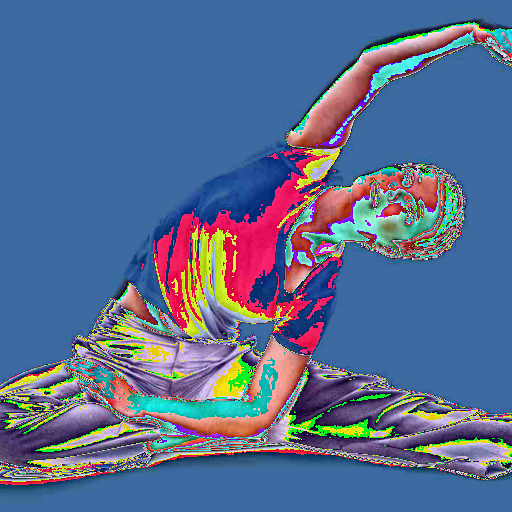

In [5]:
Image.fromarray(np.array(np.squeeze(np.transpose(img, (1, 2, 0))).numpy() * 255.0, dtype=np.uint8))

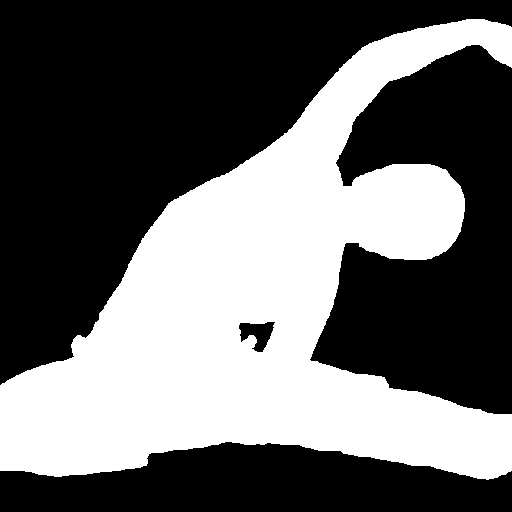

In [6]:
Image.fromarray(np.array(np.squeeze(np.transpose(mask, (1, 2, 0))).numpy() * 255.0, dtype=np.uint8))

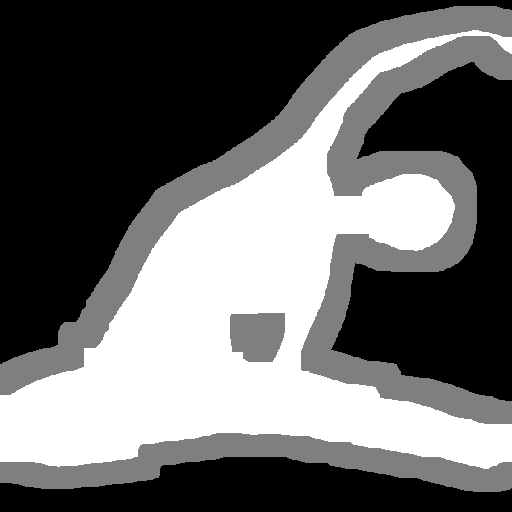

In [7]:
Image.fromarray(np.array(np.squeeze(np.transpose(trimap, (1, 2, 0))).numpy() * 255.0, dtype=np.uint8))

In [1]:
import random
import cv2

In [2]:
img_path = "/home/ubuntu/data/workspace/deeplabv3_plus/people_segmentation/images/active-athletic-exercise-female-40974.jpg"

In [22]:
img = cv2.imread(img_path, cv2.IMREAD_COLOR)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img = cv2.resize(img, (300, 180))

In [23]:
ref_size = 512
# 将短边缩短到512
im_h, im_w, im_c = img.shape

print((img.shape))

if im_w >= im_h:
    im_rh = ref_size
    im_rw = int(im_w / im_h * ref_size)
elif im_w < im_h:
    im_rw = ref_size
    im_rh = int(im_h / im_w * ref_size)

im_rw = im_rw - im_rw % 32
im_rh = im_rh - im_rh % 32
print((im_rh, im_rw))

img = cv2.resize(img, (im_rw, im_rh), interpolation=cv2.INTER_AREA)

# 随机裁剪出512x512
bigger_side = max(im_rw, im_rh)
rand_ind = random.randint(0, bigger_side - ref_size)

if im_rh > im_rw:
    img = img[rand_ind:rand_ind+ref_size, :]
else:
    img = img[:, rand_ind:rand_ind+ref_size]

# 随机翻转
if random.random()<0.5:
    img = cv2.flip(img, 1)
print(img.shape)

(180, 300, 3)
(512, 832)
(512, 512, 3)


In [24]:
512 / 832

0.6153846153846154

In [25]:
180 / 300

0.6

In [12]:
im_w

288

In [8]:
img.shape

(512, 288, 3)